In [ ]:
!pip install kaggle

In [ ]:
# Upload kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Import Twitter dataset
# !kaggle datasets download -d kazanova/sentiment140

In [ ]:
# Extracting the ZipFIle
import zipfile
zip = zipfile.ZipFile("/content/drive/MyDrive/sentiment140.zip") # Change filepath as per requirement
zip.extractall("/content/drive/MyDrive/twitter_sentiment/")
zip.close()

In [ ]:
# Importing Dependanceies
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Printing the stopwords in English
stop_words = stopwords.words("english")

In [ ]:
  # Load Data
  columns = ["target",'ID',"date_time","query","username","text"]
  twitter_data = pd.read_csv("/content/drive/MyDrive/twitter_sentiment/training.1600000.processed.noemoticon.csv",names=columns,encoding="ISO-8859-1")
twitter_data.head()

,target,ID,date_time,query,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
twitter_data.duplicated().sum()

np.int64(0)

In [ ]:
for col in twitter_data.columns:
    n_duplicates = twitter_data[col].duplicated().sum()
    print(f"Column '{col}': {n_duplicates} duplicate values")

Column 'target': 1599998 duplicate values
Column 'ID': 1685 duplicate values
Column 'date_time': 825637 duplicate values
Column 'query': 1599999 duplicate values
Column 'username': 940225 duplicate values
Column 'text': 18534 duplicate values


In [ ]:
twitter_data.shape

(1600000, 6)

In [ ]:
# Check for null values
twitter_data.isnull().sum()

,0
target,0
ID,0
date_time,0
query,0
username,0
text,0


In [ ]:
# Check for target column distribution
twitter_data["target"].value_counts()
# Observation : Balances Dataset, no supsampling , downsampling required

,count
target,
0,800000
4,800000


In [ ]:
# Change target column values from 4-->1
#  Negative: 0, Positive: 1
twitter_data.loc[twitter_data["target"] == 4, "target"] = 1
twitter_data["target"].value_counts()

,count
target,
0,800000
1,800000


In [ ]:
# Stemming : Reducing the word to the root word
# eg. actor, actress, acting --> act

In [ ]:
port_stem = PorterStemmer()

def stemming(text):
  stemmed_text = re.sub("[^a-zA-Z]"," ",text)
  stemmed_text = stemmed_text.lower()
  stemmed_text = stemmed_text.split()
  stemmed_text = [port_stem.stem(word) for word in stemmed_text if not word in stop_words]
  stemmed_text = " ".join(stemmed_text)
  return stemmed_text

In [ ]:
# twitter_data["stemmed_text"]= twitter_data["text"].apply(stemming) #Uncomment for execution

KeyboardInterrupt: 

In [ ]:
#Saving the cleaned dataset for future use
# twitter_data.to_csv("/content/drive/MyDrive/twitter_sentiment/cleaned_dataset.csv")

# Loading the preprocessed dataset

In [ ]:
twitter_data = pd.read_csv("/content/drive/MyDrive/twitter_sentiment/cleaned_dataset.csv")

In [ ]:
twitter_data.head()

,Unnamed: 0,target,ID,date_time,query,username,text,stemmed_text
0,0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [ ]:
print("Shape before removing duplicates:", twitter_data.shape)
twitter_data.drop_duplicates(subset=['stemmed_text'], inplace=True)
print("Shape after removing duplicates:", twitter_data.shape)

Shape before removing duplicates: (1600000, 8)
Shape after removing duplicates: (1546303, 8)


In [ ]:
X = twitter_data["stemmed_text"].values
y = twitter_data["target"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
print("X_train.shape",X_train.shape)
print("X_test.shape",X_test.shape)
print("y_train.shape",y_train.shape)
print("y_test.shape",y_test.shape)

X_train.shape (1237042,)
X_test.shape (309261,)
y_train.shape (1237042,)
y_test.shape (309261,)


# Vectorisation

In [ ]:
vectorizer = TfidfVectorizer()

# Fill NaN values with empty strings before vectorization
X_train = np.array([str(x) if pd.notna(x) else '' for x in X_train])
X_test = np.array([str(x) if pd.notna(x) else '' for x in X_test])

vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
import pickle

# Define the filepath for saving the vectorizer
vectorizer_filepath = "/content/drive/MyDrive/twitter_sentiment/tfidf_vectorizer.pkl"

# Save the vectorizer object
with open(vectorizer_filepath, 'wb') as file:
    pickle.dump(vectorizer, file)

print(f"TfidfVectorizer saved to {vectorizer_filepath}")

# Logistic Regression Model

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred = log_reg.predict(X_test)

In [ ]:
acc_score = accuracy_score(y_test,y_pred)
print("Accuracy Score : ",acc_score)

Accuracy Score :  0.7740064217602608


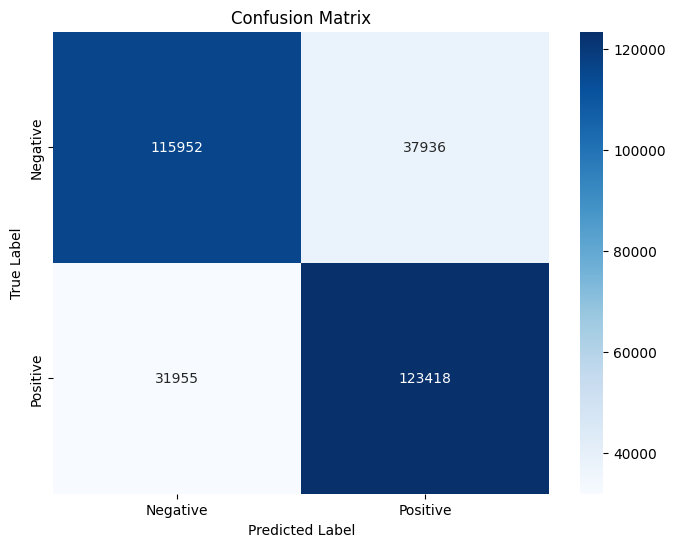

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

,precision,recall,f1-score,support
0,0.783952,0.753483,0.768416,153888.000000
1,0.764890,0.794334,0.779334,155373.000000
accuracy,0.774006,0.774006,0.774006,0.774006
macro avg,0.774421,0.773908,0.773875,309261.000000
weighted avg,0.774375,0.774006,0.773901,309261.000000


Based on the classification report and the confusion matrix:

The model has an overall accuracy of approximately 77.7%.

The precision for predicting negative sentiment (label 0) is about 78.8%, meaning that when the model predicts a tweet is negative, it is correct about 78.8% of the time.

The recall for negative sentiment is about 75.7%, meaning that the model correctly identifies about 75.7% of all actual negative tweets.

The precision for predicting positive sentiment (label 1) is about 76.6%, meaning that when the model predicts a tweet is positive, it is correct about 76.6% of the time.

The recall for positive sentiment is about 79.7%, meaning that the model correctly identifies about 79.7% of all actual positive tweets.

The confusion matrix shows that the model has a slightly higher number of false positives (predicting positive when it's negative) than false negatives (predicting negative when it's positive).

Overall, the model performs reasonably well, with balanced precision and recall for both positive and negative classes.

# Saving the model

In [ ]:
import pickle
filepath="/content/drive/MyDrive/twitter_sentiment/trained_lr_model.sav"
pickle.dump(log_reg,open(filepath,'wb'))

In [ ]:
#  Using the saved model
loaded_model = pickle.load(open("/content/drive/MyDrive/twitter_sentiment/trained_lr_model.sav","rb"))

In [ ]:
X_new = X_test[777]
print(y_test[777])

prediction = loaded_model.predict(X_new)

1


In [ ]:
if prediction == 0:
  print("Negative tweet")
else:
  print("Positive tweet")

Positive tweet


# XGB Classifier

In [ ]:
!pip install xgboost

In [ ]:
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

In [ ]:
twitter_data = pd.read_csv("/content/drive/MyDrive/twitter_sentiment/cleaned_dataset.csv")

In [ ]:
twitter_data = twitter_data.dropna(subset=["stemmed_text","target"],axis=0)

In [ ]:
X = twitter_data["stemmed_text"].values
y = twitter_data["target"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
# Use saved vectorizer
loaded_vectorizer = pickle.load(open("/content/drive/MyDrive/twitter_sentiment/tfidf_vectorizer.pkl","rb"))
X_train = loaded_vectorizer.transform(X_train)
X_test = loaded_vectorizer.transform(X_test)

In [ ]:
xgb_clf = xgboost.XGBClassifier()
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.7389723695768379
              precision    recall  f1-score   support

           0       0.79      0.65      0.71    159948
           1       0.70      0.83      0.76    159953

    accuracy                           0.74    319901
   macro avg       0.75      0.74      0.74    319901
weighted avg       0.75      0.74      0.74    319901

[[104083  55865]
 [ 27638 132315]]


In [ ]:
# Save the xgb_model
filepath="/content/drive/MyDrive/twitter_sentiment/trained_xgb_model.sav"
pickle.dump(xgb_clf,open(filepath,'wb'))

# Multinomial Naive Bayes Model

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and train the Multinomial Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_nb = nb_model.predict(X_test)

# Evaluate the model
print("Accuracy Score (Naive Bayes):", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report (Naive Bayes):\n", classification_report(y_test, y_pred_nb))
print("\nConfusion Matrix (Naive Bayes):\n", confusion_matrix(y_test, y_pred_nb))

Accuracy Score (Naive Bayes): 0.7527557629316338

Classification Report (Naive Bayes):
               precision    recall  f1-score   support

           0       0.74      0.77      0.76    153888
           1       0.77      0.73      0.75    155373

    accuracy                           0.75    309261
   macro avg       0.75      0.75      0.75    309261
weighted avg       0.75      0.75      0.75    309261


Confusion Matrix (Naive Bayes):
 [[119244  34644]
 [ 41819 113554]]


# SVM Classifier

In [ ]:
# from sklearn.svm import LinearSVC

# # Initialize and train the LinearSVC model
# svm_model = LinearSVC(random_state=42)
# svm_model.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred_svm = svm_model.predict(X_test)

# # Evaluate the model
# print("Accuracy Score (SVM):")
# print(accuracy_score(y_test, y_pred_svm))

# print("\nClassification Report (SVM):\n")
# print(classification_report(y_test, y_pred_svm))

# print("\nConfusion Matrix (SVM):\n")
# print(confusion_matrix(y_test, y_pred_svm))

# # Visualize the confusion matrix as a heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix for SVM Model')
# plt.show()

# LSTM Solution

In [ ]:
# Prepare Text for LSTM
# Re-extract stemmed_text and target
# Split into train-test
# Text tokenisation
# Pad text sequences to uniform
# Build and compile the model - Embedding layer , LSTM layers
# Train LSTM models
# Evaluate performance


In [ ]:
X_lstm = twitter_data["stemmed_text"].values
y_lstm = twitter_data["target"].values

In [ ]:
X_train_lstm,X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm,y_lstm,random_state=42, test_size=0.3)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize Tokenizer
tokenizer = Tokenizer(num_words=None, oov_token="<unk>")

# Fill NaN values with empty strings before vectorization
X_train_lstm = np.array([str(x) if pd.notna(x) else '' for x in X_train_lstm])
X_test_lstm = np.array([str(x) if pd.notna(x) else '' for x in X_test_lstm])

# Fit tokenizer on training text data
tokenizer.fit_on_texts(X_train_lstm)

# Convert text to sequences of integers
X_train_sequences = tokenizer.texts_to_sequences(X_train_lstm)
X_test_sequences = tokenizer.texts_to_sequences(X_test_lstm)

# Determine maximum sequence length for padding
# You can choose a fixed max_len or calculate it dynamically
max_len = max([len(x) for x in X_train_sequences]) # Using max length from training sequences
print(f"Maximum sequence length: {max_len}")

# Pad sequences to a uniform length
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')

print("Shape of X_train_padded:", X_train_padded.shape)
print("Shape of X_test_padded:", X_test_padded.shape)

Maximum sequence length: 37
Shape of X_train_padded: (1082412, 37)
Shape of X_test_padded: (463891, 37)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

# 2. Determine vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocab_size}")

# 3. Define embedding_dim and max_len
embedding_dim = 128
max_len = max([len(x) for x in X_train_sequences])
print(f"Embedding Dimension: {embedding_dim}")
print(f"Max Sequence Length: {max_len}")

# 4. Create a Sequential model
model = Sequential()

# 5. Add an Embedding layer
# The input_shape for the Embedding layer should be (max_len,) to represent the input sequence length
model.add(Embedding(vocab_size, embedding_dim, input_shape=(max_len,)))

# 6. Add a SpatialDropout1D layer
model.add(SpatialDropout1D(0.2))

# 7. Add an LSTM layer
model.add(LSTM(128))

# 8. Add a Dense layer with 'relu' activation
model.add(Dense(64, activation='relu'))

# 9. Add a final Dense output layer with 'sigmoid' activation
model.add(Dense(1, activation='sigmoid'))

# 10. Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary to show the built model with parameter counts
model.summary()

Vocabulary Size: 422602
Embedding Dimension: 128
Max Sequence Length: 37


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 37, 128)        │    54,093,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 37, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,232,961 (206.88 MB)

 Trainable params: 54,232,961 (206.88 MB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
The Keras warning about `input_shape`/`input_dim` in the `Embedding` layer is a suggestion, not an error preventing the model from being built. The model has been successfully defined and compiled as indicated by the printed summary and parameter counts. The next logical step in the task is to train the LSTM model.



In [ ]:
## Train LSTM Model

## Train LSTM Model

**Reasoning**:
The model has been built and compiled. The next step is to train the LSTM model using the padded training data and corresponding labels, following the overall task instructions.



In [ ]:
history = model.fit(X_train_padded, y_train_lstm, epochs=3, batch_size=256, validation_split=0.2)

Epoch 1/3
3383/3383 ━━━━━━━━━━━━━━━━━━━━ 134s 38ms/step - accuracy: 0.6360 - loss: 0.6124 - val_accuracy: 0.7729 - val_loss: 0.4723
Epoch 2/3
3383/3383 ━━━━━━━━━━━━━━━━━━━━ 129s 38ms/step - accuracy: 0.8097 - loss: 0.4148 - val_accuracy: 0.7746 - val_loss: 0.4706
Epoch 3/3
3383/3383 ━━━━━━━━━━━━━━━━━━━━ 129s 38ms/step - accuracy: 0.8677 - loss: 0.3087 - val_accuracy: 0.7630 - val_loss: 0.5259


14497/14497 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step
Accuracy Score (LSTM Model): 0.7645

Classification Report (LSTM Model):

              precision    recall  f1-score   support

           0       0.74      0.80      0.77    230583
           1       0.79      0.73      0.76    233308

    accuracy                           0.76    463891
   macro avg       0.77      0.76      0.76    463891
weighted avg       0.77      0.76      0.76    463891



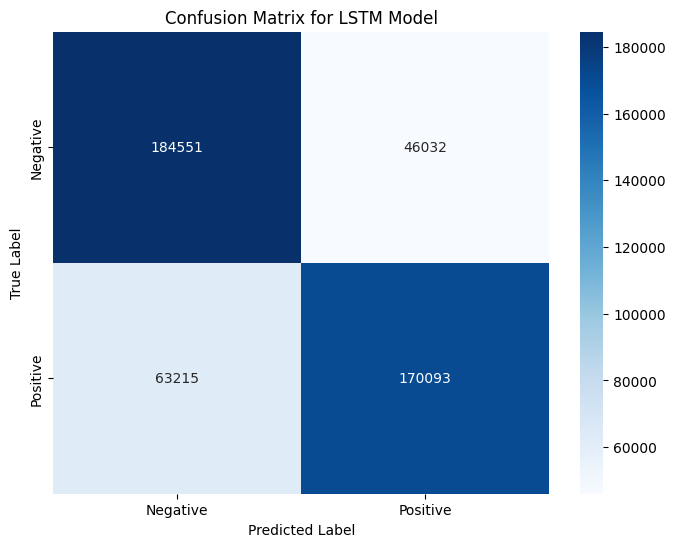

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Make predictions on the test set
y_pred_prob = model.predict(X_test_padded)

# Convert probabilities to binary class labels (0 or 1) using a threshold of 0.5
y_pred_lstm = (y_pred_prob > 0.5).astype(int)

# 2. Calculate and print the accuracy score
accuracy_lstm = accuracy_score(y_test_lstm, y_pred_lstm)
print(f"Accuracy Score (LSTM Model): {accuracy_lstm:.4f}")

# 3. Generate and print the classification report
print("\nClassification Report (LSTM Model):\n")
print(classification_report(y_test_lstm, y_pred_lstm))

# 4. Compute the confusion matrix
conf_mat_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)

# 5. Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for LSTM Model')
plt.show()

## Build an Improved Bi-Directional LSTM Model


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
twitter_data = pd.read_csv("/content/drive/MyDrive/twitter_sentiment/cleaned_dataset.csv")

In [ ]:
X_lstm = twitter_data["stemmed_text"].values
y_lstm = twitter_data["target"].values

In [ ]:
X_train_lstm,X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm,y_lstm,random_state=42, test_size=0.3)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize Tokenizer
tokenizer = Tokenizer(num_words=None, oov_token="<unk>")

# Fill NaN values with empty strings before vectorization
X_train_lstm = np.array([str(x) if pd.notna(x) else '' for x in X_train_lstm])
X_test_lstm = np.array([str(x) if pd.notna(x) else '' for x in X_test_lstm])

# Fit tokenizer on training text data
tokenizer.fit_on_texts(X_train_lstm)

# Convert text to sequences of integers
X_train_sequences = tokenizer.texts_to_sequences(X_train_lstm)
X_test_sequences = tokenizer.texts_to_sequences(X_test_lstm)

# Determine maximum sequence length for padding
# You can choose a fixed max_len or calculate it dynamically
max_len = max([len(x) for x in X_train_sequences]) # Using max length from training sequences
print(f"Maximum sequence length: {max_len}")

# Pad sequences to a uniform length
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')

print("Shape of X_train_padded:", X_train_padded.shape)
print("Shape of X_test_padded:", X_test_padded.shape)

Maximum sequence length: 50
Shape of X_train_padded: (1120000, 50)
Shape of X_test_padded: (480000, 50)


In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout


# 2. Determine vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocab_size}")

# 3. Define embedding_dim and max_len
embedding_dim = 128
max_len = max([len(x) for x in X_train_sequences])
print(f"Embedding Dimension: {embedding_dim}")
print(f"Max Sequence Length: {max_len}")


# Create a new Sequential model instance
improved_model = Sequential()

# Add an Embedding layer
improved_model.add(Embedding(vocab_size, embedding_dim, input_shape=(max_len,)))

# Add a SpatialDropout1D layer
improved_model.add(SpatialDropout1D(0.2))

# Add a Bidirectional wrapper around an LSTM layer with 256 units
improved_model.add(Bidirectional(LSTM(256)))

# Add a Dropout layer with a dropout rate of 0.2
improved_model.add(Dropout(0.2))

# Add a Dense layer with 64 units and 'relu' activation
improved_model.add(Dense(64, activation='relu'))

# Add a final Dense output layer with 1 unit and 'sigmoid' activation
improved_model.add(Dense(1, activation='sigmoid'))

# Compile the model
improved_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary to display the new model's architecture and parameter counts
improved_model.summary()

Vocabulary Size: 422208
Embedding Dimension: 128
Max Sequence Length: 50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 128)        │    54,042,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 50, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512)            │       788,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,864,001 (209.29 MB)

 Trainable params: 54,864,001 (209.29 MB)

 Non-trainable params: 0 (0.00 B)

Bi-Directional LTSM model training

In [ ]:
history_improved = improved_model.fit(X_train_padded, y_train_lstm, epochs=3, batch_size=256, validation_split=0.2)

Epoch 1/3
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 222s 60ms/step - accuracy: 0.7508 - loss: 0.4993 - val_accuracy: 0.7850 - val_loss: 0.4529
Epoch 2/3
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 206s 59ms/step - accuracy: 0.8351 - loss: 0.3729 - val_accuracy: 0.7764 - val_loss: 0.4737
Epoch 3/3
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 205s 59ms/step - accuracy: 0.8788 - loss: 0.2834 - val_accuracy: 0.7681 - val_loss: 0.5261


## Evaluate Improved Bi-LSTM Model Performance



15000/15000 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step
Accuracy Score (Improved LSTM Model): 0.7689

Classification Report (Improved LSTM Model):

              precision    recall  f1-score   support

           0       0.77      0.76      0.77    239361
           1       0.76      0.78      0.77    240639

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



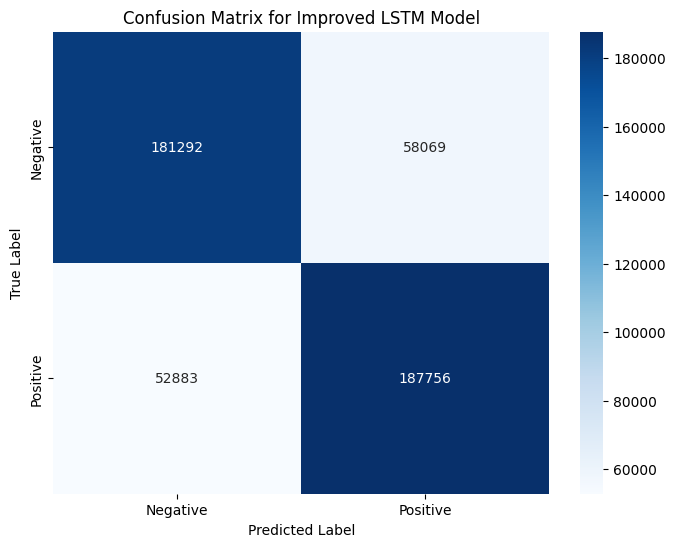

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Make predictions on the test set
y_pred_prob_improved = improved_model.predict(X_test_padded)

# Convert probabilities to binary class labels (0 or 1) using a threshold of 0.5
y_pred_improved = (y_pred_prob_improved > 0.5).astype(int)

# 2. Calculate and print the accuracy score
accuracy_improved = accuracy_score(y_test_lstm, y_pred_improved)
print(f"Accuracy Score (Improved LSTM Model): {accuracy_improved:.4f}")

# 3. Generate and print the classification report
print("\nClassification Report (Improved LSTM Model):\n")
print(classification_report(y_test_lstm, y_pred_improved))

# 4. Compute the confusion matrix
conf_mat_improved = confusion_matrix(y_test_lstm, y_pred_improved)

# 5. Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_improved, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Improved LSTM Model')
plt.show()

# Transformer-Based Solution

In [ ]:
!pip install transformers torch accelerate -qqq

## Data Preparation for Transformers

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
import torch

In [ ]:
twitter_data = pd.read_csv("/content/drive/MyDrive/twitter_sentiment/cleaned_dataset.csv")

In [ ]:
twitter_data.shape

(1600000, 8)

In [ ]:
# Drop missing values from both columns together
twitter_data_clean = twitter_data.dropna(subset=["stemmed_text", "target"])

subset = twitter_data_clean.sample(frac=0.08,random_state=42,axis=0)

# # Take 8% sample safely
# subset_size = int(len(twitter_data_clean) * 0.05)
# subset = twitter_data_clean.iloc[:subset_size].copy()

# Extract text and labels together
X_transformer = subset["stemmed_text"].astype(str).tolist()
y_transformer = subset["target"].tolist()

print(len(X_transformer), len(y_transformer))

127960 127960


In [ ]:
# Check
X_transformer[:10],y_transformer[:10]

(['neighbor kindli chang tire clean gonna get free movi redbox l r hafta studi day busybusi',
  'jaxin good night see variou board tomorrow hope week start awesom',
  'mattfollowil good luck leno amp mtv movi award make sure u countri punk garag la ass amp stay pure king love u',
  'jeremythurb well im glad excit someth',
  'guess she awak',
  'oric yeah realli like miss qdoba hood though',
  'reagent new quot mother day quot gift geesh least honest',
  'gunjan joshi incred psych hear congratul truli happi',
  'katiejonesi game',
  'rain'],
 [1, 1, 1, 1, 0, 0, 0, 1, 0, 0])

In [ ]:
# Split data into training and testing sets
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_transformer, y_transformer, test_size=0.2, random_state=42, stratify=y_transformer)

len(X_train_tf), len(X_test_tf), len(y_train_tf), len(y_test_tf)

(102368, 25592, 102368, 25592)

In [ ]:
#Checking
type(X_train_tf), type(y_train_tf), type(X_test_tf), type(y_test_tf)

(list, list, list, list)

In [ ]:
#Checking
type(X_train_tf[0]), type(X_test_tf[0]),

In [ ]:
#  Checking
for i in range(3):
    print(repr(X_train_tf[i]))

In [ ]:
# Convert all to strings safely and drop weird cases
X_train_tf = [str(x) for x in X_train_tf if isinstance(x, (str, int, float))]
X_test_tf  = [str(x) for x in X_test_tf if isinstance(x, (str, int, float))]

# Remove obvious placeholders
X_train_tf = [x for x in X_train_tf if x.strip().lower() not in ["nan", "none", "null", ""]]
X_test_tf  = [x for x in X_test_tf if x.strip().lower() not in ["nan", "none", "null", ""]]


In [ ]:
# Tokenize and re-create datasets to reflect the reduced sizes
MODEL_NAME = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

train_encodings = tokenizer(X_train_tf, truncation=True, padding=True, max_length=64)
test_encodings  = tokenizer(X_test_tf, truncation=True, padding=True, max_length=64)


In [ ]:
#  Checking shapes
print(len(train_encodings["input_ids"]), len(y_train_tf))
print(len(test_encodings["input_ids"]), len(y_test_tf))

102368 102368
25592 25592


In [ ]:
# Create datasets again with the reduced and re-tokenized data
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train_tf)).shuffle(10000).batch(16)
test_dataset  = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test_tf)).batch(16)

print(f"New Training dataset size: {len(train_dataset)}")
print(f"New Test dataset size: {len(test_dataset)}")

print(type(train_dataset),type(test_dataset))

New Training dataset size: 6398
New Test dataset size: 1600
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'> <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [ ]:
import tensorflow as tf, keras, tf_keras
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("TF-Keras:", tf_keras.__version__)


TensorFlow: 2.19.0
Keras: 3.10.0
TF-Keras: 2.19.0


In [ ]:
MODEL_NAME = "distilbert-base-uncased"
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2, from_pt=True)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.AdamW(learning_rate=3e-5, weight_decay=0.01)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

In [ ]:
model.fit(train_dataset, validation_data=test_dataset, epochs=3)

Epoch 1/3
6398/6398 [==============================] - 1044s 152ms/step - loss: 0.5050 - accuracy: 0.7503 - val_loss: 0.4794 - val_accuracy: 0.7688
Epoch 2/3
6398/6398 [==============================] - 781s 122ms/step - loss: 0.4235 - accuracy: 0.8043 - val_loss: 0.4877 - val_accuracy: 0.7633
Epoch 3/3
6398/6398 [==============================] - 780s 122ms/step - loss: 0.3157 - accuracy: 0.8656 - val_loss: 0.5709 - val_accuracy: 0.7615


In [ ]:
import os

# Define the directory to save the transformer model and tokenizer
save_directory = "/content/drive/MyDrive/twitter_sentiment/transformer_model2"

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)
print(f"Tokenizer saved to {save_directory}")

# Save the model
model.save_pretrained(save_directory)
print(f"Transformer model saved to {save_directory}")

Tokenizer saved to /content/drive/MyDrive/twitter_sentiment/transformer_model2
Transformer model saved to /content/drive/MyDrive/twitter_sentiment/transformer_model2


In [ ]:
import os
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification

# Define the directory where the model and tokenizer were saved
save_directory = "/content/drive/MyDrive/twitter_sentiment/transformer_model2"

# Load the tokenizer
loaded_tokenizer = DistilBertTokenizerFast.from_pretrained(save_directory)
print("Tokenizer loaded successfully!")

# Load the model
loaded_model_transformer = TFDistilBertForSequenceClassification.from_pretrained(save_directory)
print("Transformer model loaded successfully!")

### Use the loaded model for prediction

In [ ]:
import numpy as np
import tensorflow as tf

def predict_sentiment_transformer(text):
    # Tokenize the input text
    inputs = loaded_tokenizer(text, truncation=True, padding=True, return_tensors="tf")

    # Make prediction
    outputs = loaded_model_transformer(inputs)
    logits = outputs.logits

    # Get probabilities and predicted class
    probabilities = tf.nn.softmax(logits, axis=-1)
    predicted_class = tf.argmax(probabilities, axis=1).numpy()[0]

    return "Positive" if predicted_class == 1 else "Negative"

# Example usage:
example_text = "This is a great movie, I loved it!"
sentiment = predict_sentiment_transformer(example_text)
print(f"Text: '{example_text}'\nPredicted Sentiment: {sentiment}")

example_text_2 = "I hate this weather, it's so bad."
sentiment_2 = predict_sentiment_transformer(example_text_2)
print(f"\nText: '{example_text_2}'\nPredicted Sentiment: {sentiment_2}")

## Evaluate Transformer Model

1600/1600 [==============================] - 95s 58ms/step
Accuracy Score (Transformer Model): 0.7615

Classification Report (Transformer Model):

              precision    recall  f1-score   support

           0       0.75      0.78      0.77     12766
           1       0.77      0.74      0.76     12826

    accuracy                           0.76     25592
   macro avg       0.76      0.76      0.76     25592
weighted avg       0.76      0.76      0.76     25592



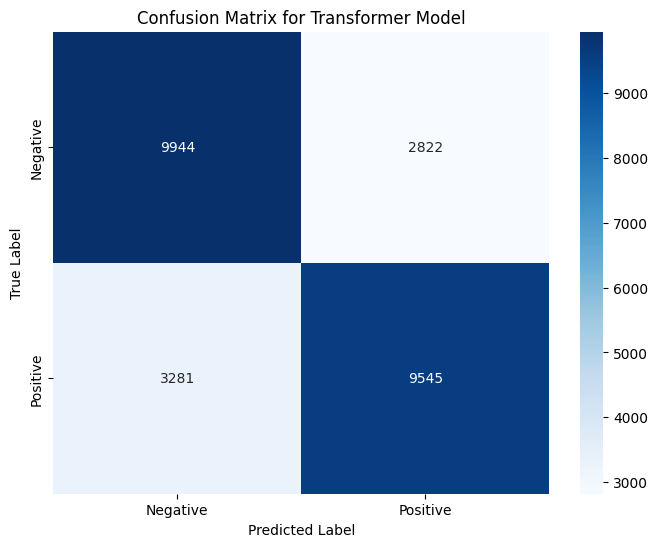

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the test set
predictions = model.predict(test_dataset)

# Extract predicted labels (logits) and convert them to class labels
y_pred_logits = predictions.logits
y_pred_transformer = np.argmax(y_pred_logits, axis=1)

# Collect true labels from the test_dataset by iterating through it
y_true_transformer = []
for _, labels in test_dataset:
    y_true_transformer.extend(labels.numpy())
y_true_transformer = np.array(y_true_transformer)

# Calculate and print the accuracy score
accuracy_transformer = accuracy_score(y_true_transformer, y_pred_transformer)
print(f"Accuracy Score (Transformer Model): {accuracy_transformer:.4f}")

# Generate and print the classification report
print("\nClassification Report (Transformer Model):\n")
print(classification_report(y_true_transformer, y_pred_transformer))

# Compute the confusion matrix
conf_mat_transformer = confusion_matrix(y_true_transformer, y_pred_transformer)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_transformer, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Transformer Model')
plt.show()

## Save Best Model and Preprocessor

### Subtask:
Save the trained `log_reg` model and the `TfidfVectorizer` (`vectorizer`) using `pickle` so they can be loaded by the Streamlit application.


**Reasoning**:
The subtask requires saving the `TfidfVectorizer` object. I will use the `pickle` library to serialize the `vectorizer` and save it to the specified filepath.



In [ ]:
import pickle

# Define the filepath for saving the vectorizer
vectorizer_filepath = "/content/drive/MyDrive/twitter_sentiment/tfidf_vectorizer.pkl"

# Save the vectorizer object
with open(vectorizer_filepath, 'wb') as file:
    pickle.dump(vectorizer, file)

print(f"TfidfVectorizer saved to {vectorizer_filepath}")

TfidfVectorizer saved to /content/drive/MyDrive/twitter_sentiment/tfidf_vectorizer.pkl


## Create Streamlit Application File

### Subtask:
Create a new Python file named `app.py` that will contain the Streamlit application code.


**Reasoning**:
The subtask is to create an empty Python file named `app.py`. A shell command using `touch` is the most direct way to achieve this.



In [ ]:
import os

# Define the directory path
app_dir = "/content/drive/MyDrive/twitter_sentiment/"

# Ensure the directory exists
os.makedirs(app_dir, exist_ok=True)

# Define the full path for app.py
app_filepath = os.path.join(app_dir, "app.py")

# Create an empty app.py file
with open(app_filepath, 'w') as f:
    pass

print(f"Empty app.py created at: {app_filepath}")

Empty app.py created at: /content/drive/MyDrive/twitter_sentiment/app.py


# Streamlit application logic within the `app.py` file.



In [ ]:
%%writefile /content/drive/MyDrive/twitter_sentiment/app.py

import streamlit as st
import pickle
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Ensure NLTK data is downloaded
try:
    nltk.data.find('corpora/stopwords')
except:
    nltk.download('stopwords')

# Load stopwords and stemmer
stop_words = set(stopwords.words('english'))
port_stem = PorterStemmer()

# Define the stemming function (same as used during training)
def stemming(text):
    if not isinstance(text, str): # Handle potential non-string input
        return ""
    stemmed_text = re.sub("[^a-zA-Z]"," ",text)
    stemmed_text = stemmed_text.lower()
    stemmed_text = stemmed_text.split()
    stemmed_text = [port_stem.stem(word) for word in stemmed_text if word not in stop_words]
    stemmed_text = " ".join(stemmed_text)
    return stemmed_text

# Load the trained model and vectorizer
try:
    model_filepath = "/content/drive/MyDrive/twitter_sentiment/trained_lr_model.sav"
    vectorizer_filepath = "/content/drive/MyDrive/twitter_sentiment/tfidf_vectorizer.pkl"

    with open(model_filepath, 'rb') as model_file:
        loaded_model = pickle.load(model_file)

    with open(vectorizer_filepath, 'rb') as vectorizer_file:
        vectorizer = pickle.load(vectorizer_file)

    st.success("Model and Vectorizer loaded successfully!")
except Exception as e:
    st.error(f"Error loading model or vectorizer: {e}")
    st.stop() # Stop the app if models cannot be loaded

# Streamlit app title and description
st.title("Twitter Sentiment Analysis App")
st.write("Enter a tweet below to predict its sentiment (Positive or Negative).")

# Text input from user
user_input = st.text_area("Enter tweet here:", "I love this new product!")

if st.button("Analyze Sentiment"):
    if user_input.strip() == "":
        st.warning("Please enter some text to analyze.")
    else:
        # Preprocess the user input
        preprocessed_input = stemming(user_input)

        # Vectorize the preprocessed input
        # TfidfVectorizer expects an iterable, so pass it as a list
        vectorized_input = vectorizer.transform([preprocessed_input])

        # Make prediction
        prediction = loaded_model.predict(vectorized_input)

        # Display result
        if prediction[0] == 0:
            st.error("Negative Sentiment")
        else:
            st.success("Positive Sentiment")

st.markdown("---")
st.info("This app uses a Logistic Regression model trained on a large dataset of Twitter sentiment.")


Overwriting /content/drive/MyDrive/twitter_sentiment/app.py


## Provide Deployment Instructions

### Subtask:
Generate clear, step-by-step instructions on how to install dependencies and run the Streamlit application locally.

### Instructions to Run the Streamlit Application:

To run the Streamlit application (`app.py`) for Twitter Sentiment Analysis, follow these steps:

1.  **Ensure you have Python installed** (version 3.7+ is recommended).

2.  **Navigate to the directory** where `app.py` is saved. In this case, it is `/content/drive/MyDrive/twitter_sentiment/`.

    ```bash
    cd /content/drive/MyDrive/twitter_sentiment/
    ```

3.  **Install the required Python packages**. You can create a `requirements.txt` file or install them directly:

    ```bash
    # Option 1: Create a requirements.txt (recommended for deployment)
    # Create a file named requirements.txt in the same directory as app.py with the following content:
    # streamlit
    # numpy
    # pandas
    # scikit-learn # For TfidfVectorizer and LogisticRegression
    # nltk

    # Then install using pip:
    pip install -r requirements.txt

    # Option 2: Install directly (if you prefer not to use requirements.txt)
    pip install streamlit numpy pandas scikit-learn nltk
    ```

4.  **Download NLTK data** (if not already downloaded by the app's `try-except` block):

    ```python
    import nltk
    nltk.download('stopwords')
    ```

5.  **Run the Streamlit application** from your terminal:

    ```bash
    streamlit run app.py
    ```

6.  **Access the application**. After running the command, Streamlit will typically open a new tab in your default web browser (or provide a URL) to access the application. If it doesn't open automatically, look for a message in your terminal similar to:

    ```
    You can now view your Streamlit app in your browser.

    Local URL: http://localhost:8501
    Network URL: http://<your_ip_address>:8501
    ```

    Open the provided Local URL in your web browser.

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Deployment Part

In [ ]:
pip install streamlit numpy pandas scikit-learn nltk pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 85.2 MB/s eta 0:00:00


In [ ]:
import os
os.chdir('/content/drive/MyDrive/twitter_sentiment/')
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://172.28.0.12:8502
  External URL: http://34.106.203.130:8502

  Stopping...
  Stopping...


In [ ]:
import os
import time
import subprocess
from pyngrok import ngrok

# Kill previous tunnels
ngrok.kill()

# Add your token
NGROK_AUTH_TOKEN = "35dOIHJThOmsVpcJtJuMsODZAi4_6hkT1PByThnZ7B4KrgWjS"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Streamlit settings
PORT = 8501
APP_DIR = "/content/drive/MyDrive/twitter_sentiment/"
os.chdir(APP_DIR)

# Start Streamlit
print("Starting Streamlit...")
process = subprocess.Popen(
    ["streamlit", "run", "app.py",
    "--server.address", "0.0.0.0",        # ← REQUIRED
     "--server.port", str(PORT),
     "--server.enableCORS", "false",
     "--server.enableXsrfProtection", "false"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
)

# Wait for Streamlit to boot
time.sleep(10)

# Start ngrok tunnel
print("Connecting ngrok...")
public_url = ngrok.connect(PORT)
print("🚀 Streamlit Public URL:", public_url)


Starting Streamlit...
Connecting ngrok...
🚀 Streamlit Public URL: NgrokTunnel: "https://proresearch-overbrutally-samual.ngrok-free.dev" -> "http://localhost:8501"


After running the above cell, it will print an `Ngrok Tunnel URL`. Please use that URL to access your Streamlit application.

**Important**: Make sure you have set your `NGROK_AUTH_TOKEN` in Colab's secrets. You can find this under the key icon on the left panel. Name the secret `NGROK_AUTH_TOKEN`.